# Analysis of Transcription Factor Activities ( 3receptor subtypes )

**Goal: ** predict different breast cancer subtypes using TF activities.
- We re-estimate TF activities using the inferred network -- only interactions with support in at least 60% of the bootstraps.    
- Activities are then used as predictors of 3receptor subtypes ('TNBC', 'ER', 'ERBB2') for each cell line. 
- We train a logistic regression with elastic net penalty and pick parameters alpha and l1_ratio by 3-fold cross-validation.
- Then, we plot a network expanded from the chosen predictors.
- Finally, we plot boxplots of activities for some TFs in each subtype

In [3]:
import sys
if ".." not in sys.path:
    sys.path.append("..")
    
import numpy as np
import pandas as pd
from tfa import *
from jp_gene_viz import dNetwork
from jp_gene_viz import multiple_network
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

### Subset Network (60% bootstraps and TFs w/ at least 5 targets)

In [4]:
network = pd.read_csv('network_breast_cancer_Marcotte2016_BBSR1.1_combinedPriors_TfsPriors.tsv', sep = '\t')
network = network.loc[network['bootstraps'] >= 12,:]
network = pd.pivot_table(network, index = 'target', columns = 'regulator', values = 'bootstraps', fill_value = 0)
network = network.loc[:,(network != 0).sum(axis=0) >= 5]
del network.columns.name
del network.index.name

### Prepare expression, and calculate TFA (pseudo-inverse)

In [8]:
expression = pd.read_csv('expression_cell_lines.tsv', sep = '\t', index_col = 0)
expression_filt = expression.loc[expression.index.intersection(network.index),:]
tfa_calculator = TFA(network, expression_filt, expression_filt)
activities = tfa_calculator.compute_transcription_factor_activity()

### Train Logistic Regression Classifier

In [9]:
# metadata containing subtype labels
metadata = pd.read_csv('metadata_cell_lines.txt', sep = '\t')

# prepare data for fitting model
X = StandardScaler().fit_transform(activities.transpose())
y = metadata['subtype_3receptor'].tolist()

# search space for alpha and l1_ratio parameter
param_grid = {'alpha': np.linspace(0.001, 1, 50),              
              'l1_ratio': np.linspace(0.1, 1, 20)}

# run 3-fold cross-validation
clf = GridSearchCV(SGDClassifier(loss = 'log', 
                                 penalty='elasticnet',
                                 class_weight = 'balanced',
                                 random_state = 42),
                                 param_grid,
                                 refit=True,
                                 n_jobs = -1,
                                 cv = 3)
clf = clf.fit(X, y)

# cross-validation results
cv_results = pd.DataFrame(clf.cv_results_)

model = SGDClassifier(alpha = clf.best_params_['alpha'],
                      l1_ratio = clf.best_params_['l1_ratio'],
                      penalty='elasticnet',
                      loss = 'log',
                      random_state = 42,
                      class_weight='balanced')

model.fit(X, y)

SGDClassifier(alpha=0.14371428571428571, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.76315789473684215, learning_rate='optimal', loss='log',
       n_iter=5, n_jobs=1, penalty='elasticnet', power_t=0.5,
       random_state=42, shuffle=True, verbose=0, warm_start=False)

### CV and Training Scores

In [29]:
TNBC_accuracy = (clf.predict(X)[['TNBC' == label for label in y]] == np.asarray(y)[['TNBC' == label for label in y]]).sum()/float(np.sum(['TNBC' == label for label in y]))
ER_accuracy = (clf.predict(X)[['ER' == label for label in y]] == np.asarray(y)[['ER' == label for label in y]]).sum()/float(np.sum(['ER' == label for label in y]))
ERBB2_accuracy = (clf.predict(X)[['ERBB2' == label for label in y]] == np.asarray(y)[['ERBB2' == label for label in y]]).sum()/float(np.sum(['ERBB2' == label for label in y]))
print 'Per subtype training accuracy'
print 'ER prediction score: ' + str(ER_accuracy)
print 'ERBB2 prediction score: ' + str(ERBB2_accuracy)
print 'TNBC prediction score: ' + str(TNBC_accuracy)

Per subtype training accuracy
ER prediction score: 0.85
ERBB2 prediction score: 0.647058823529
TNBC prediction score: 0.955555555556


In [11]:
train_score = (clf.predict(X) == y).sum()/float(len(y))
cv_score = cv_results['mean_test_score'].max()
print 'Cross-validation Score: {}'.format(cv_score)
print 'Training Score: {}'.format(train_score)

Cross-validation Score: 0.817073170732
Training Score: 0.865853658537


###  ER discriminating regulators (chosen by classifier)

In [12]:
genes = np.asarray(activities.index)[(model.coef_[0,:] != 0)]
coefficients = model.coef_[0,:][(model.coef_[0,:] != 0)]
df = pd.DataFrame([genes, coefficients]).transpose()
df['sort'] = df[1].abs()
df = df.sort_values('sort', ascending = False).drop('sort', axis=1)
preds_0 = df[0][df[1].abs() >= 0.1]
df

,0,1
2,ESR1,0.562814
10,WT1,-0.347116
8,RXRG,0.117456
3,ETV6,0.106092
4,FOSL1,0.0910136
0,BCL6,-0.0613775
9,SP4,0.0536179
5,HNF1A,-0.0400435
6,NFIL3,0.0369509
7,NR0B1,0.0286749


### ERBB2 discriminating regulators (chosen by classifier)

In [13]:
genes = np.asarray(activities.index)[(model.coef_[1,:] != 0)]
coefficients = model.coef_[1,:][(model.coef_[1,:] != 0)]
df = pd.DataFrame([genes, coefficients]).transpose()
df['sort'] = df[1].abs()
df = df.sort_values('sort', ascending = False).drop('sort', axis=1)
preds_1 = df[0][df[1].abs() >= 0.1]
df

,0,1
1,AR,0.632814
3,ELF5,0.450168
9,TP63,-0.327379
10,VDR,-0.280267
6,NR2C1,-0.143967
4,ELK4,0.129558
7,SPDEF,0.117922
2,EGR4,0.0741816
5,MEIS2,0.0399966
0,AHR,0.035864


### TNBC discriminating regulators (chosen by classifier)

In [14]:
genes = np.asarray(activities.index)[(model.coef_[2,:] != 0)]
coefficients = model.coef_[2,:][(model.coef_[2,:] != 0)]
df = pd.DataFrame([genes, coefficients]).transpose()
df['sort'] = df[1].abs()
df = df.sort_values('sort', ascending = False).drop('sort', axis=1)
preds_2 = df[0][df[1].abs() >= 0.1]
df

,0,1
0,EMX2,-0.365838
1,ETV6,-0.203089
5,STAT6,-0.190305
4,NFKB2,0.177839
3,MEF2C,-0.131847
2,FOXA2,-0.0498315


In [30]:
dNetwork.load_javascript_support()

predictors = [np.asarray(activities.index)[(model.coef_[i,:] != 0)] for i in range(3)]
predictors = np.concatenate(predictors).tolist()
#predictors = np.concatenate([preds_0, preds_1, preds_2]) # top predictors

def network_config(N, gene_list, title, threshhold):
    N.threshhold_slider.value = threshhold
    N.apply_click(None)
    N.pattern_text.value = ' '.join(gene_list)
    N.match_click(None)
    N.expand_click(None)
    N.layout_dropdown.value = 'kamada_kawai'
    N.layout_click(None)
    N.labels_button.value = True
    N.labels_click(None)
    #N.container_dropdown.value = 'SVG'
    N.title_html.value = title
    return(N)

N1 = dNetwork.display_network('network_breast_cancer_Marcotte2016_BBSR1.1_combinedPriors_TfsPriors.tsv', show = False)
N1 = network_config(N1, predictors, 'TFs predictive 3receptor subtypes', 11)

('Reading network', 'network_breast_cancer_Marcotte2016_BBSR1.1_combinedPriors_TfsPriors.tsv')
('Loading saved layout', 'network_breast_cancer_Marcotte2016_BBSR1.1_combinedPriors_TfsPriors.tsv.layout.json')
Omitting edges, using canvas, and fast layout default because the network is large


In [31]:
N1.show()

###  Boxplot Estimated TFA for chosen TFs

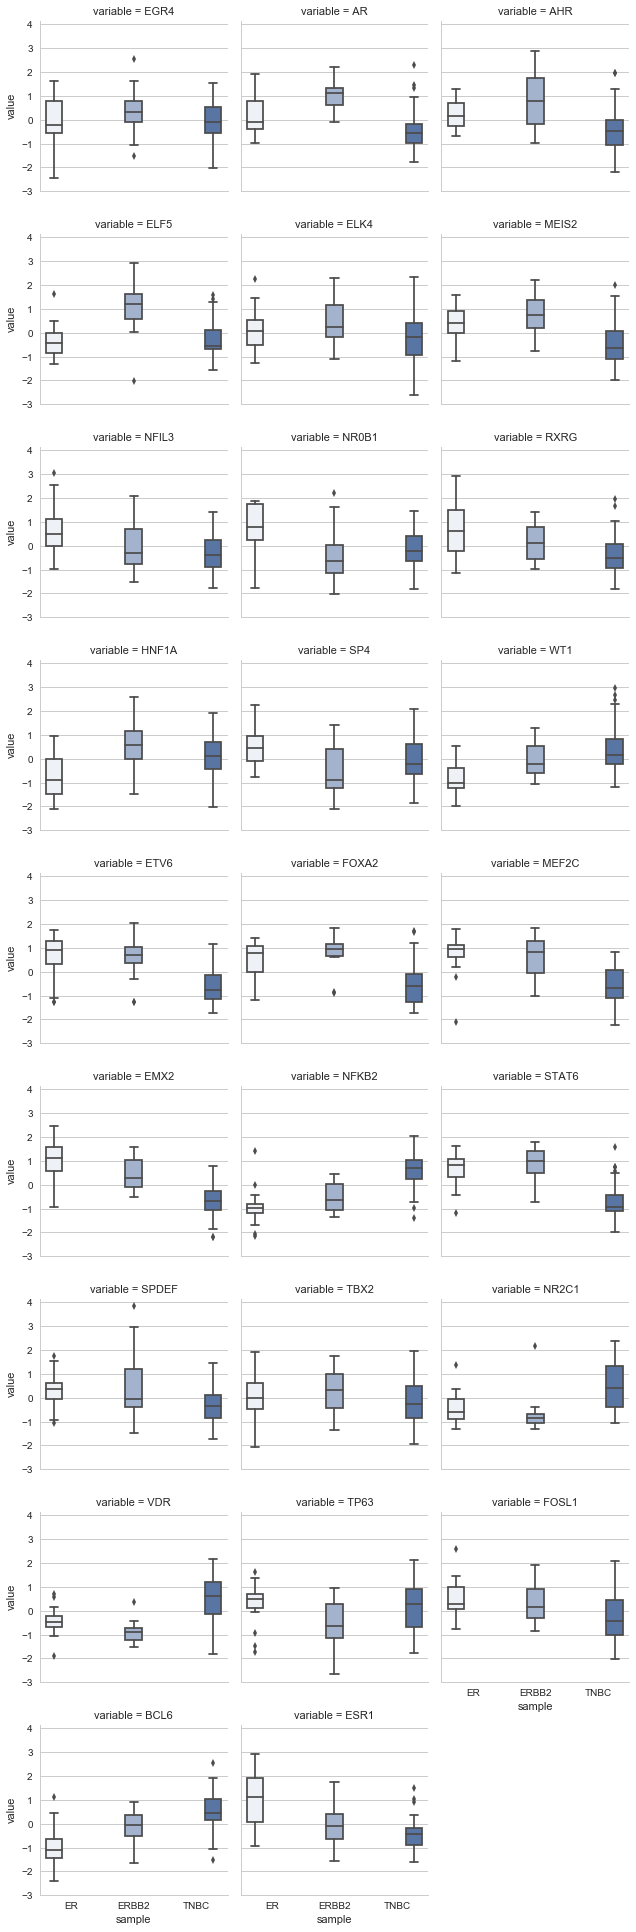

In [32]:
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid")

pred_activities = StandardScaler().fit_transform(activities.loc[predictors,:].transpose())
pred_activities = pd.DataFrame(pred_activities, columns = predictors)
pred_activities['sample'] = metadata['subtype_3receptor']
df = pd.melt(pred_activities, id_vars = 'sample')
df = df.sort_values('sample')

g = sns.FacetGrid(df, col='variable', col_wrap = 3, margin_titles=True)
g.map(sns.boxplot, 'sample', 'value', 'sample')

###  Boxplot Expression for chosen TFs

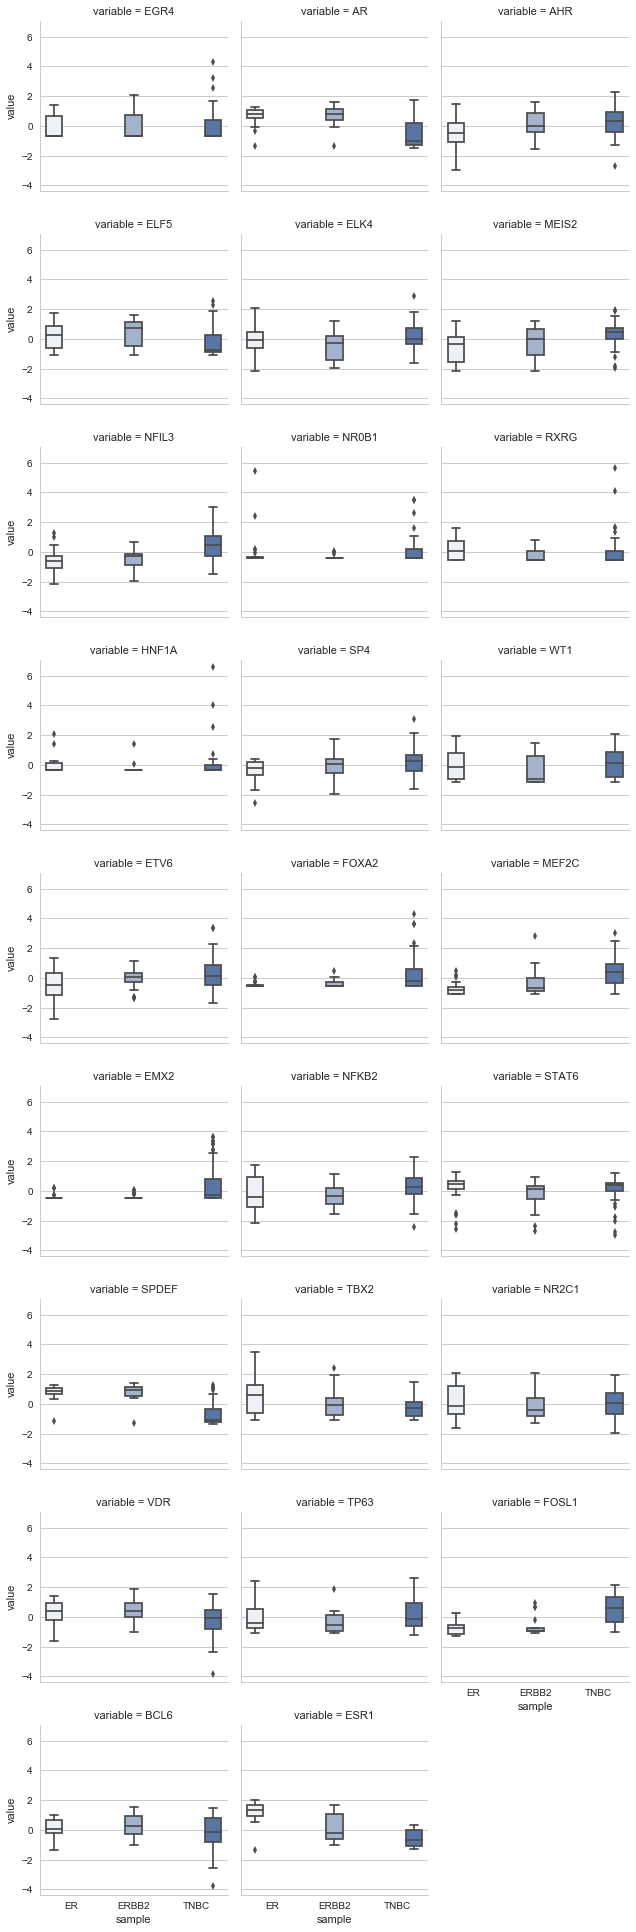

In [33]:
pred_expression = StandardScaler().fit_transform(expression.loc[predictors,:].transpose())
pred_expression = pd.DataFrame(pred_expression, columns = predictors)
pred_expression['sample'] = metadata['subtype_3receptor']
df = pd.melt(pred_expression, id_vars = 'sample')
df = df.sort_values('sample')
g = sns.FacetGrid(df, col='variable', col_wrap = 3, margin_titles=True)
g.map(sns.boxplot, 'sample', 'value', 'sample')

###  Boxplot Estimated TFA for other TFs  I picked 

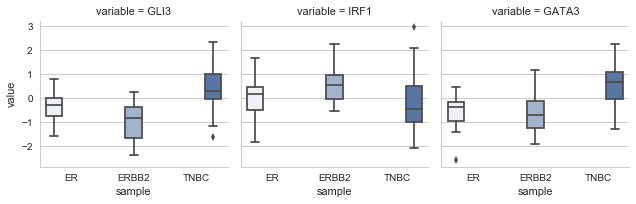

In [27]:
predictors = ['GATA3', 'IRF1', 'GLI3']
pred_activities = StandardScaler().fit_transform(activities.loc[predictors,:].transpose())
pred_activities = pd.DataFrame(pred_activities, columns = predictors)
pred_activities['sample'] = metadata['subtype_3receptor']
df = pd.melt(pred_activities, id_vars = 'sample')
df = df.sort_values('sample')

g = sns.FacetGrid(df, col='variable', col_wrap = 3, margin_titles=True)
g.map(sns.boxplot, 'sample', 'value', 'sample')

###  Boxplot Expression for other TFs  I picked 

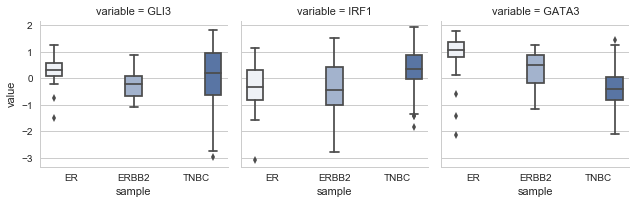

In [28]:
pred_expression = StandardScaler().fit_transform(expression.loc[predictors,:].transpose())
pred_expression = pd.DataFrame(pred_expression, columns = predictors)
pred_expression['sample'] = metadata['subtype_3receptor']
df = pd.melt(pred_expression, id_vars = 'sample')
df = df.sort_values('sample')
g = sns.FacetGrid(df, col='variable', col_wrap = 3, margin_titles=True)
g.map(sns.boxplot, 'sample', 'value', 'sample')